In [17]:
##First, I load all the packages that will be needed during this project:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [18]:
##and then, I read the file that contains the details of all the flights that occured in 2015. I output some 
#informations concerning the types of the variables in the dataframe and the quantity of null values for each 
#variable:
df = pd.read_csv('/home/pk/Downloads/flights--01.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (100099, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,167,0,0,0,2301,2301,2374,2374,0,2616,2616,0,2443,2443,0,2443,2616,0,0,97707,65450,65450,65450,65450,65450
null values (%),0,0,0,0,0,0,0.166835,0,0,0,2.29872,2.29872,2.37165,2.37165,0,2.61341,2.61341,0,2.44058,2.44058,0,2.44058,2.61341,0,0,97.6104,65.3853,65.3853,65.3853,65.3853,65.3853


In [19]:
#Each entry of the `flights.csv` file corresponds to a flight.
#These flights are described according to 31 variables.

In [20]:
#an addtional file airport.csv is also given
airports = pd.read_csv("/home/pk/Downloads/airports.csv")

In [21]:
##Given the large size of the dataset, I decide to consider only a subset of the data in order to reduce the 
#computational time.I will just keep the flights from January 2015:
df = df[df['MONTH'] == 1]

In [22]:
##  Cleaning
## Dates and times
##In the initial dataframe, dates are coded according to 4 variables: **YEAR, MONTH, DAY**, and **DAY_OF_WEEK**. 
##In fact, python offers the **_datetime_** format which is really convenient to work with dates and times and I 
##thus convert the dates in this format:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [23]:
##Schedule departure section
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [24]:
##to modify the dataframe variables
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [25]:
#Finally, we clean the dataframe throwing the variables we won't use and re-organize the columns 
#to ease its reading:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235,215.0


In [26]:
##At this stage, we can examine how complete the dataset is:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,2616,97.386587
1,ELAPSED_TIME,2616,97.386587
2,ARRIVAL_TIME,2443,97.559416
3,DEPARTURE_TIME,2301,97.701276
4,DEPARTURE_DELAY,2301,97.701276
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [27]:
##We see that the variables filling factor is quite good (> 97%). Since the scope of this work is not to 
##establish the state-of-the-art in predicting flight delays, I decide to proceed without trying to impute 
##what's missing and 23 simply remove the entries that contain missing values.
df.dropna(inplace = True)

In [28]:
#Comparing airlines
airlines_names = pd.read_csv('/home/pk/Downloads/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [29]:
##For further use, I put the content of this this dataframe in a dictionary:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()   

In [30]:
###  Basic statistical description of airlines
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
AIRLINE,,,,
VX,1035.0,359.0,7.937198,-16.0
HA,1327.0,830.0,8.512434,-13.0
F9,1518.0,516.0,33.023057,-21.0
NK,1793.0,557.0,27.482432,-23.0
AS,2832.0,444.0,7.049788,-39.0
B6,4665.0,500.0,18.438371,-24.0
MQ,5418.0,780.0,33.795127,-19.0
US,6903.0,362.0,11.003477,-20.0
UA,8337.0,886.0,24.113230,-19.0


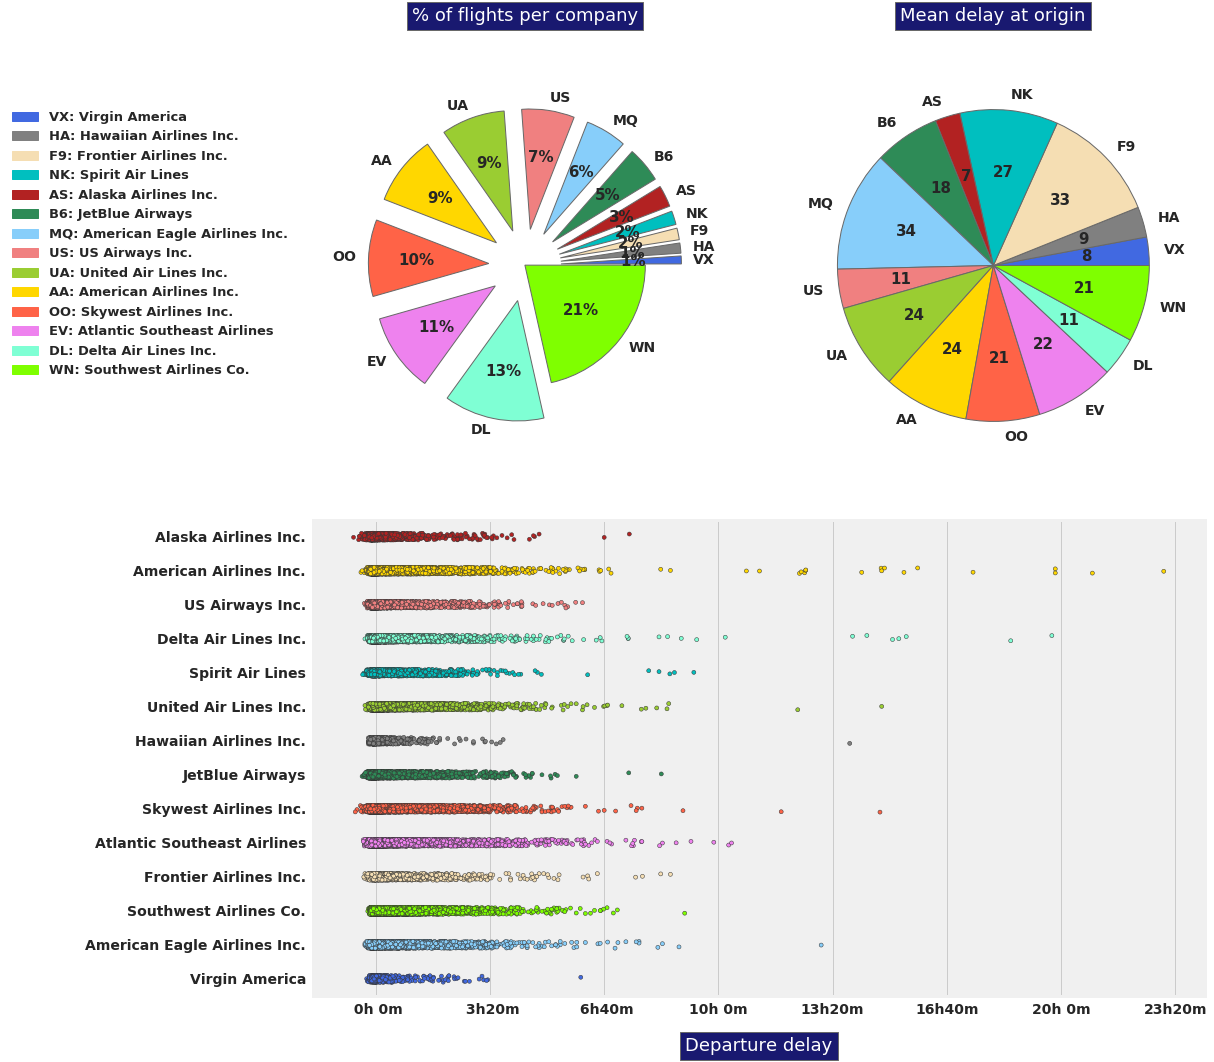

In [31]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

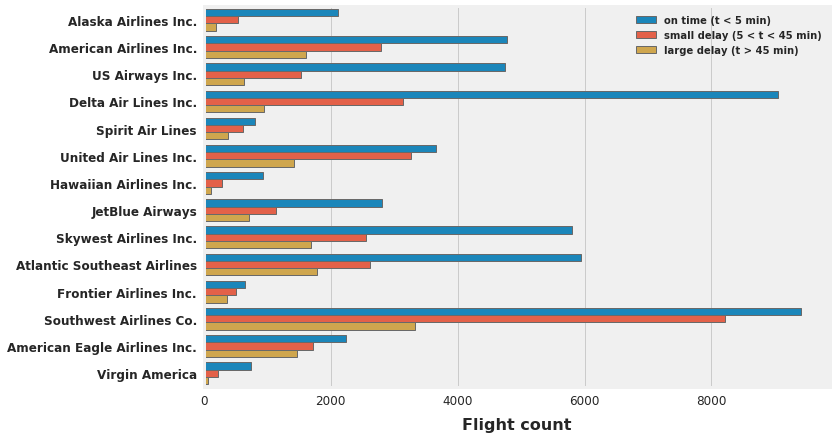

In [32]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

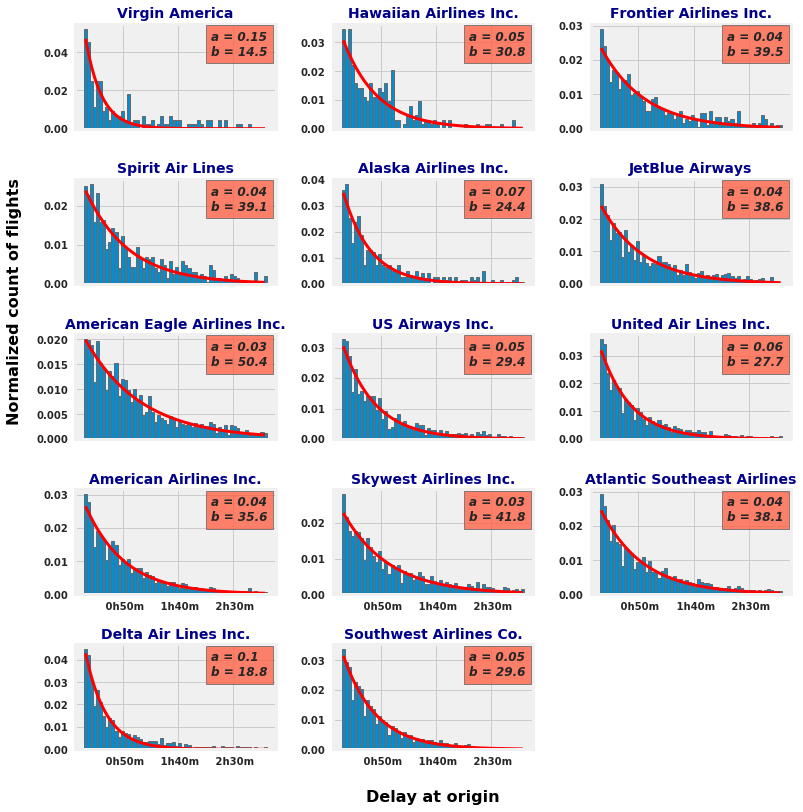

In [33]:
###  Delays distribution: establishing the ranking of airlines
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

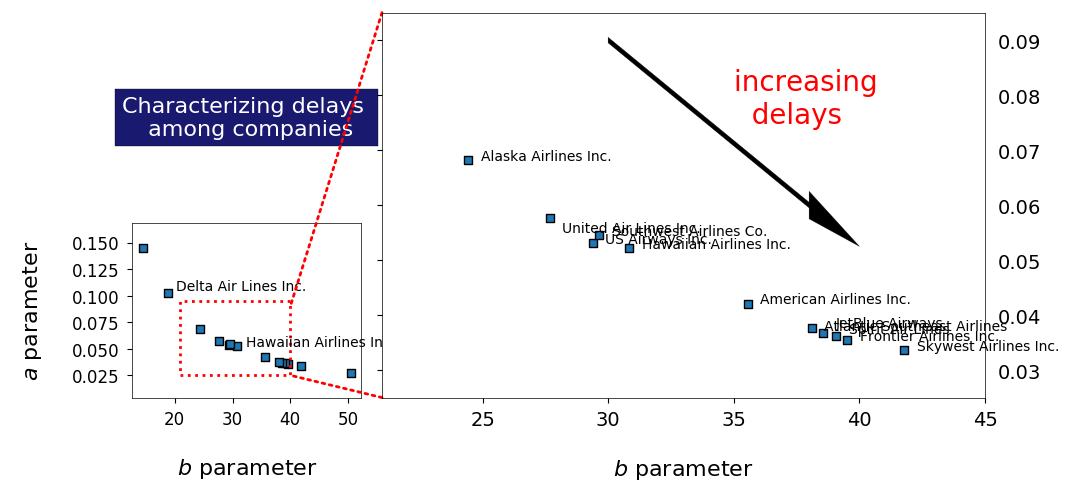

In [34]:
##This figure shows the normalised distribution of delays that we
##modelised with an exponential distribution $ f(x) = a \, \mathrm{exp} (-x/b)
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

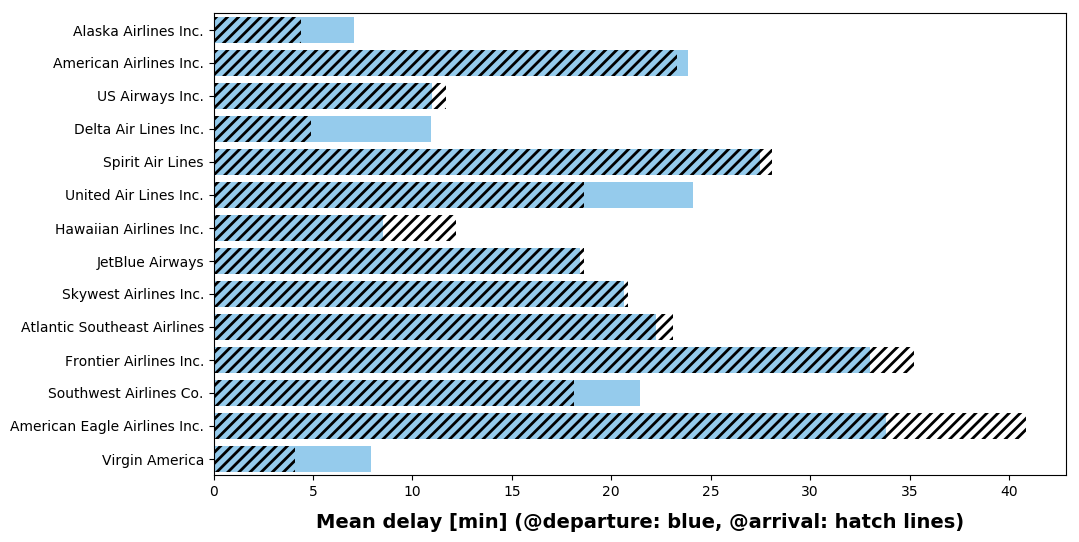

In [35]:
#Delays take off or landing
##In the previous section, all the discussion was done on departure delays. However, these delays 
#differ somewhat from the delays recorded at arrival:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [36]:
##  Relation between the origin airport and delays
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312


In [37]:
## How the origin airport impact delays
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

NameError: name 'identify_airport' is not defined

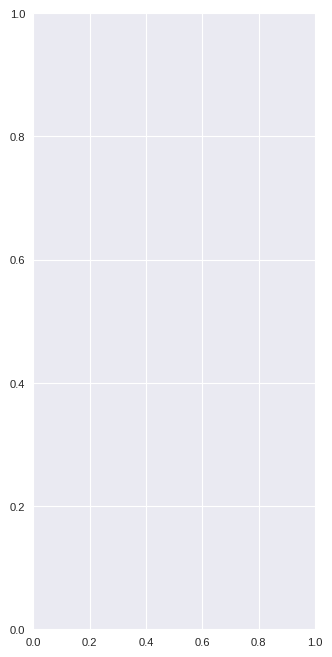

In [38]:
#representing the subset of data
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

In [39]:
## Flights with usual delays 
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()


In [40]:
##the average delay on the various paths A->B, as well as
##the standard deviation and once done, I create a graphical representation (for a sample of the flights):
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

NameError: name 'identify_airport' is not defined

In [41]:
## Predicting delays epoch $23->31 of Januaray
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

In [42]:
### 5.1 Model 1: one airline, one airport
##model the delays by considering separately the different airlines and by splitting the data according to the 
#different home airports. This first model can be seen as a *"toy-model"*  that enables to identify problems 
#hat may arise at the  production stage. When treating the whole dataset,  the number of fits will be large. 
#Hence we have to be sure that the automation of the whole process is robust enough to insure the quality of the 
#fits.
#*a) Unsufficient statistics**

#First of all, I consider the *American Airlines* flights and make a census of the number of flights that left each
#airport:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,count,max,mean,min
ORIGIN_AIRPORT,,,,
LIT,9.0,74.0,12.555556,-5.0
JAC,8.0,9.0,-5.625000,-17.0
GUC,6.0,199.0,39.333333,-4.0
SDF,5.0,16.0,0.400000,-6.0
MTJ,1.0,51.0,51.000000,51.0


In [43]:
# Extreme delays
#Another pitfall to avoid is that of "accidental" delays: a particular attention should be paid to extreme delays. 
#Indeed, during the exploration, it was seen that occasionally, delays of several hours (even tens of hours) could 
#be recorded. This type of delay is however marginal (a few %) and the cause of these delays is probably linked to 
#unpredictable events (weather, breakdown, accident, ...). On the other hand, taking into account a delay of this 
#type will likely introduce a bias in the analysis. Moreover, the weight taken by large values will be significant 

#In order to illustrate this, I first define a function that calculates the mean flights delay per airline and per 
#airport: 
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [44]:
##and then a function that performs a linear regression on these values:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [45]:
 ##then consider two scenarios. In the first case, I take all the initial values and in the second case, I 
##eliminate all delays greater than 1h before calculating the average delay. The comparison of the two cases is 
##quite explicit:
id_airport = 'PHL'
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

In [46]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['heure_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

NameError: name 'Figure_style' is not defined

In [47]:
##a) Bias introduced by the separation of the data set
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

In [48]:
##b) selection by cross validation
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))

In [52]:
##This class has two methods:
## train (n, nb_folds): defined 'nb_folds' training sets from the initial dataset and drives a 'n' order 
#polynomial on each of these sets. This method returns as a result the Y predictions obtained for the different 
#test sets.
##** calc_score (n, nb_folds) **: performs the same procedure as a ** train ** method except that this method 
##calculates the fit score and not the predicted values on the different test data.
#id_airport = 1129804 

nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Max possible number of folds: 12 

n=1 -> MSE = 394.262
n=2 -> MSE = 356.812
n=3 -> MSE = 504.156
n=4 -> MSE = 573.519
n=5 -> MSE = 746.36
n=6 -> MSE = 1055.427
n=7 -> MSE = 1552.981


In [53]:
##We can see that using this method gives us that the best model (ie the best generalized model) is obtained with 
##a polynomial of order 2. At this stage of the procedure, the choice of the polynomial order a has been validated and we can now use all the data in order to perform the fita:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)

In [54]:
##Thus, in the following figure, the juxtaposition of the K = 50 polynomial fits corresponding to the cross 
##validation calculation leads to the red curve. The polynomial fit corresponding to the final model corresponds 
#to the blue curve.
fit2.train(pol_order = 2, nb_folds = nb_folds)

In [55]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

NameError: name 'Figure_style' is not defined

In [56]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score##Model test: prediction of end-January delays

260.08911929392173

In [57]:
##Model test: prediction of end-January delays
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

AttributeError: 'DatetimeIndex' object has no attribute 'labels'

In [58]:
##and the MSE score of the model is:
score = metrics.mean_squared_error(fit.result, Y_test)
score

NameError: name 'Y_test' is not defined

In [59]:
##thus giving the difference in minutes between the predicted delay and the actual delay. In this case, the 
##difference between the model and the observations is thus typically:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 16.13 min'

In [60]:
##Model no.2: One airline, all airports


In [61]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [62]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(1721, 3)

In [63]:
#In the *merged_df* dataframe, airports are referenced by an identifier given in the ** ORIGIN_AIRPORT** variable.
#The corresponding labels can't be used directly in a fit and I thus use the *one-hot-encoding* method:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

In [64]:
##Above, I have assigned a label to each airport. The correspondence between the label and the original identifier 
##has been saved in the *label_airport* list. Now I proceed with the "One Hot Encoding" by creating a matrix where 
#instead of the **ORIGIN_AIRPORT** variable that contained $M$ labels, we build a matrix with $M$ columns, filled 
#of 0 and 1 depending on the correspondance with particular airports:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1721, 82) (1721, 1)


In [65]:
#### 5.2.1 Linear regression

##The matrices X and Y thus created can be used to perform a linear regression:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

MSE = 113.432572491


In [66]:
#Here, I calculated the MSE score of the fit. In practice, we can have a feeling of the quality of the fit by 
#considering the number of predictions where the differences with real values is greater than 15 minutes:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

'11.74%'

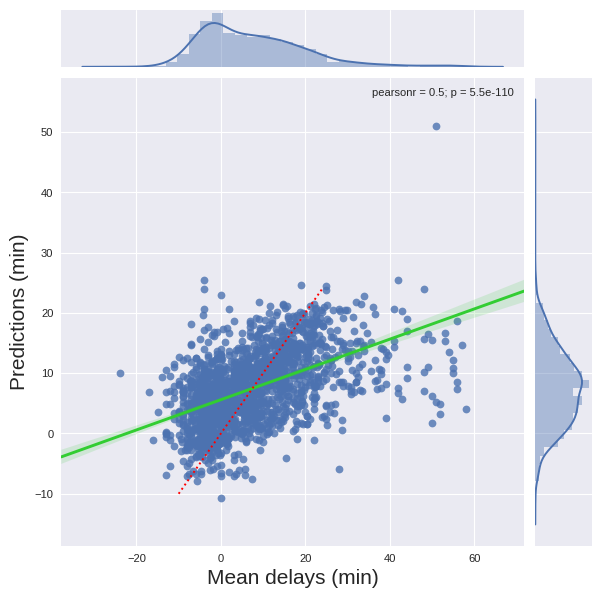

In [67]:
#in practice, this model tends to underestimate the large delays, which can be seen in the following figure:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

In [68]:
##Polynomial regression
#I will now extend the previous fit by using a 
#polynomial rather than a linear function:

In [69]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 104.307592473


In [71]:
##We can see that a polynomial fit improves slightly 
#the MSE score. In practice, the percentage of values 
#where the difference between predictions and real 
#delays is greater than 15 minutes is:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

'10.75%'

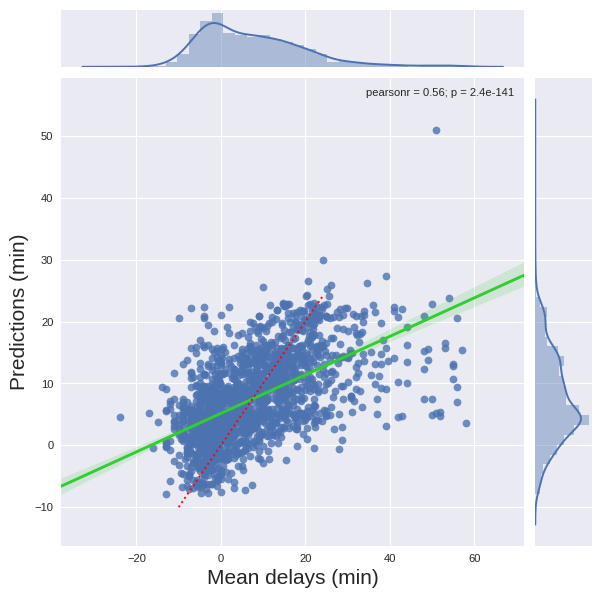

In [72]:
##And as before, it can be seen that model tends to be 
#worse in the case of large delays:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

In [73]:
# Setting the free parameters
#Above, the two models were fit and tested on the 
#training set. In practice, as mentioned above, there 
#is a risk of overfitting by proceeding that way and 
#the free parameters of the model will be biased. 
#Hence,  the model will not allow a good generalization
#In what follows, I will therefore split the datas in 
#order to train and then test the model. The purpose 
#will be to determine the polynomial degree which 
#allows the best generalization of the predictions:

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [75]:
#As before, I fit the model on the training set:

In [76]:
X_train.shape

(1204, 82)

In [77]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Mean squared error =  95.8470311282


In [78]:
#Now, by testing on the test set we get:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  61808.6332173


In [79]:
#Here, we see that the **fit is particularly bad with 
#a MSE > 500** (the exact value depends on the run and 
#on the splitting of the dataset), which means that the 
#fit performs poorly when generalyzing to other data. 
#Now let's examine in detail the reasons why we have 
#such a bad score. Below, I examing all the terms of 
#the MSE calculation and identify the largest terms:

In [81]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

104687.4 -297.6 26.0
11387.0 114.2 7.5
31752980.7 5651.2 16.2


In [82]:
#We see that some predictions show very large errors. In
#practice, this can be explained by the fact that during 
#the separation in train and test sets, **data with no 
#equivalent in the training set was put in the test data**. 
#Thus, when calculating the prediction, the model has to 
#**perform an extrapolation**. If the coefficients of the 
#fit are large (which is often the case when overfitting), 
#extrapolated values will show important values, as in the 
#present case. In order to have a control over this phenomenon,
#we can use a **regularization method** which will put a penalty 
#to the models whose coefficients are the most important:

In [83]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [84]:
#Now, if we calculate the score associated to the 
#predictions made with a regularization technique, we 
#have:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  141.118734498


In [85]:
#And we can see that we obtain a reasonnable score. 
#Hence, with the current procedure, to determine the 
#best model, we have two free parameters to adjust: 
#the polynomial order and the $\alpha$ coefficient of 
#the * 'Ridge Regression' *:

In [86]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 140.04
n=1 alpha=2 , MSE = 139.18
n=1 alpha=4 , MSE = 139.67
n=1 alpha=6 , MSE = 140.68
n=1 alpha=8 , MSE = 141.86
n=1 alpha=10 , MSE = 143.05
n=1 alpha=12 , MSE = 144.21
n=1 alpha=14 , MSE = 145.29
n=1 alpha=16 , MSE = 146.3
n=1 alpha=18 , MSE = 147.23
n=2 alpha=0 , MSE = 1.0728e+11
n=2 alpha=2 , MSE = 141.14
n=2 alpha=4 , MSE = 141.14
n=2 alpha=6 , MSE = 141.25
n=2 alpha=8 , MSE = 141.44
n=2 alpha=10 , MSE = 141.71
n=2 alpha=12 , MSE = 142.02
n=2 alpha=14 , MSE = 142.38
n=2 alpha=16 , MSE = 142.75
n=2 alpha=18 , MSE = 143.15


In [87]:
#This grid search allows to find the best set of 
#$\alpha$ and $n$ parameters. Let us note, however, 
#that for this model, the estimates obtained with a 
#linear regression or a polynomial of order 2 are 
#quite close. Now I use these parameters to test this 
#template over the test set:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

114.368402186


In [88]:
## Testing the model: delays of end-january
#At this stage, model predictions are tested against end-January data. These data are first extracted:

In [89]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

UnboundLocalError: local variable 'merged_df' referenced before assignment

In [90]:
#then I convert them into a format suitable to perform the fit. At this stage, I manually do one-hot-encoding by 
#re-using the labeling that had been established on the training data:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['heure_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

NameError: name 'merged_df_test' is not defined

In [91]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

'MSE = 124.48'

In [92]:
#assuming that the delay is independent of the point, 
#this MSE score is equivalent to an average delay of:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 11.16 min'

In [93]:
#The current MSE score is calculated on all the airports 
#served by _American Airlines_, whereas previously it was 
#calculated on the data of a single airport. The current 
#model is therefore more general. Moreover, considering 
#the previous model, it is likely that predictions will 
#be poor for airports with low statistics.